In [478]:
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
import itertools
import soundfile as sf
from sklearn import preprocessing
from IPython.display import Audio, display
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


In [635]:
def load_ravdess_data():
    path = '/home/jelena/Desktop/speech/ravdess/'
    ravdess_directory_list = os.listdir(path)

    emotions = []
    paths = []
    for dir in ravdess_directory_list:
        
        actor = os.listdir(path + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            emotions.append(int(part[2]))
            paths.append(path + dir + '/' + file)

    emotion_df = pd.DataFrame(emotions, columns=['Emotion'])
    path_df = pd.DataFrame(paths, columns=['Path'])
    
    Ravdess_df = pd.concat([path_df,emotion_df], axis=1)

    Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    
    return Ravdess_df

In [636]:
def load_tess_data():
    
    emotions = []
    paths = []
    path = "/home/jelena/Desktop/speech/Tess/"
    tess_directory_list = os.listdir(path)
    
    for file in tess_directory_list:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions.append('surprise')
        else:
            emotions.append(part)
        paths.append(path + file)

    emotion_df = pd.DataFrame(emotions, columns=['Emotion'])
    path_df = pd.DataFrame(paths, columns=['Path'])
    
    Tess_df = pd.concat([path_df, emotion_df], axis=1)
    
    return Tess_df

In [637]:
def load_data():
    ravdess = load_ravdess_data()
    tess = load_tess_data()
    
    data = pd.concat([tess, ravdess],axis=0,ignore_index=True)
    
    return data

In [640]:
data = load_data()

In [641]:
def vizualisation(data, sr, e):
    plt.title('Vizualization for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


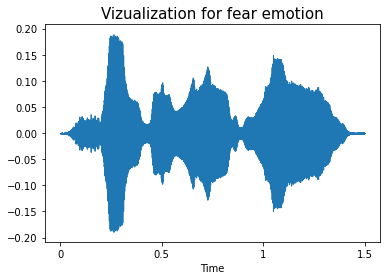

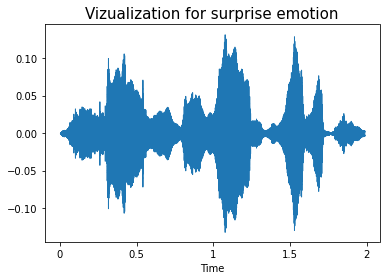

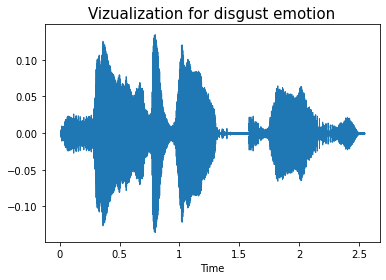

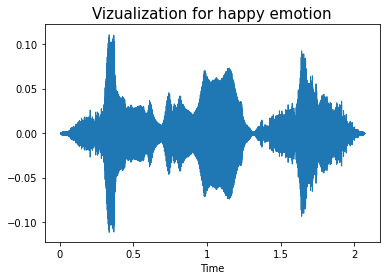

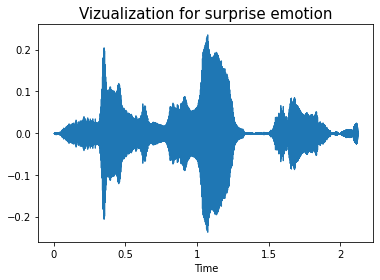

In [642]:
labels = ['neutral','happy','sad','angry','fear','disgust','surprise']
for i in range(5):
    pom_path = np.array(data['Path'])[1+i*500]
    data_, sampling_rate = librosa.load(pom_path)
    vizualisation(data_, sampling_rate, np.array(data['Emotion'])[1+i*500])
    display(Audio(pom_path))

In [643]:
def showMatrix(matrix, model):
    emotions = ['neutral','happy','sad','angry','fear','disgust','surprise']
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.set_title(
        'Confussion matrix for model ' + model,
        loc='center',
        fontsize=18,
        weight='bold'
    )
    
    colors = plt.cm.BuPu(np.linspace(0, 0.5, 7))

    plt.table(matrix,colLabels=emotions, rowLabels=emotions,loc='center',colColours=colors, rowColours=colors)
    
    return

In [644]:
def extract_mfcc(index, filename):
    with sf.SoundFile(filename) as f:
        data = f.read(dtype="float32")
        result=np.array([])
        sample_rate=f.samplerate
        
        mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
        mfccs = np.insert(mfccs, 0, index)
        result=np.hstack((result, mfccs))

        return result

In [645]:
def get_coef():
    X = []
    Y = []
    for index, row in data.iterrows():
        result = extract_mfcc(index,row[0])
        X.append(result)
        Y.append(row[1])
    return X,Y

In [646]:
X,Y = get_coef()

In [647]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.3, random_state=9,shuffle=True)

In [648]:
ss = StandardScaler()

indexes_train = np.array([x_train[:,0]]).T
indexes_test = np.array([x_test[:,0]]).T

x_train = ss.fit_transform(x_train[:,1:])
x_test = ss.transform(x_test[:,1:])

In [649]:
model1 = MLPClassifier(alpha=0.01, batch_size=128, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

In [650]:
model1.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=128, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=1000)

In [651]:
y_pred=model1.predict(x_test)

In [652]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

In [653]:
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 89.23%


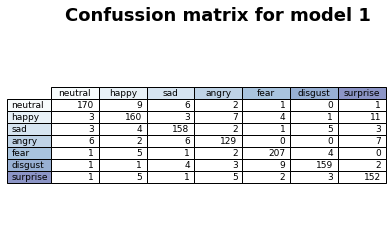

In [654]:
matrix1 = confusion_matrix(y_test, y_pred)
showMatrix(matrix1, "1")

In [668]:
misclassified = (np.where(y_test != y_pred))[0]

y_test_indexed = np.append(np.array([y_test]).T,indexes_test,axis=1)

for i in range(40,45):
    index = misclassified[i]
    true_emotion = y_test_indexed[index][0]
    predicted_emotion = y_pred[index]
    data_index = int(float(y_test_indexed[index][1]))
    
    pom_path = np.array(data['Path'])[data_index]
    display(Audio(pom_path))
    
    print("True class is " + true_emotion + "; predicted class is " + predicted_emotion + ".")

True class is sad; predicted class is happy.


True class is sad; predicted class is fear.


True class is disgust; predicted class is surprise.


True class is happy; predicted class is surprise.


True class is happy; predicted class is angry.


In [656]:
model2 = Sequential()
model2.add(Dense(input_dim = x_train.shape[1],units = 100, activation = 'relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [657]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)

y_train_pom = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(y_train_pom)

y_true_pom = encoder.transform(y_test)
dummy_y_true = np_utils.to_categorical(y_true_pom)

In [658]:
model2_history = model2.fit(x_train, dummy_y, batch_size = 64, epochs = 40, verbose = 1, validation_split=0.3)

Epoch 1/40
33/33 [==============================] - 1s 16ms/step - loss: 1.5054 - accuracy: 0.4805 - val_loss: 1.0853 - val_accuracy: 0.6521
Epoch 2/40
33/33 [==============================] - 0s 5ms/step - loss: 0.8513 - accuracy: 0.7265 - val_loss: 0.7439 - val_accuracy: 0.7385
Epoch 3/40
33/33 [==============================] - 0s 6ms/step - loss: 0.6388 - accuracy: 0.7708 - val_loss: 0.6397 - val_accuracy: 0.7744
Epoch 4/40
33/33 [==============================] - 0s 6ms/step - loss: 0.5431 - accuracy: 0.8012 - val_loss: 0.5882 - val_accuracy: 0.7912
Epoch 5/40
33/33 [==============================] - 0s 5ms/step - loss: 0.4815 - accuracy: 0.8305 - val_loss: 0.5936 - val_accuracy: 0.7755
Epoch 6/40
33/33 [==============================] - 0s 6ms/step - loss: 0.4322 - accuracy: 0.8507 - val_loss: 0.5511 - val_accuracy: 0.7957
Epoch 7/40
33/33 [==============================] - 0s 6ms/step - loss: 0.3902 - accuracy: 0.8666 - val_loss: 0.5350 - val_accuracy: 0.8058
Epoch 8/40
33/33 [=

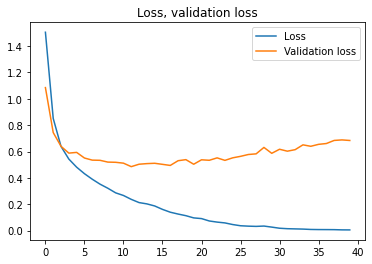

In [659]:
epochs = model2_history.epoch
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']
plt.title("Loss, validation loss")
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(["Loss","Validation loss"])

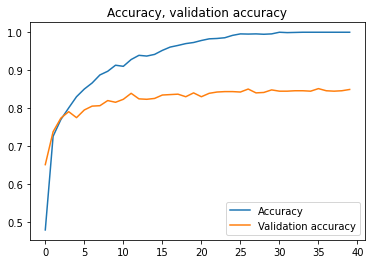

In [660]:
acc = model2_history.history['accuracy']
val_acc = model2_history.history['val_accuracy']
plt.title("Accuracy, validation accuracy")
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(["Accuracy","Validation accuracy"])

In [661]:
model2.evaluate(x_test, dummy_y_true, batch_size=64)

20/20 [==============================] - 0s 2ms/step - loss: 0.7251 - accuracy: 0.8475


[0.725147545337677, 0.847484290599823]

In [662]:
y_pred_e = np.argmax(model2.predict(x_test), axis=1)

40/40 [==============================] - 0s 3ms/step


In [663]:
accuracy = accuracy_score(y_true_pom, y_pred_e)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 84.75%


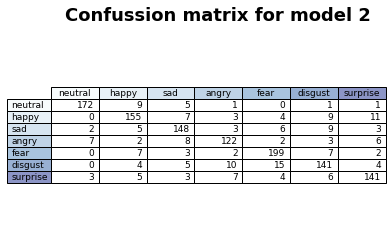

In [664]:
matrix2 = confusion_matrix(y_true_pom, y_pred_e)
showMatrix(matrix2, "2")

In [670]:
misclassified = (np.where(y_true_pom != y_pred_e))[0]

y_pred = encoder.inverse_transform(y_pred_e)
y_test_indexed = np.append(np.array([y_test]).T,indexes_test,axis=1)

for i in range(20,25):
    index = misclassified[i]
    true_emotion = y_test_indexed[index][0]
    predicted_emotion = y_pred[index]
    
    data_index = int(float(y_test_indexed[index][1]))
    pom_path = np.array(data['Path'])[data_index]
    display(Audio(pom_path))
    
    print("True class is " + true_emotion + "; predicted class is " + predicted_emotion + ".")

True class is neutral; predicted class is disgust.


True class is fear; predicted class is surprise.


True class is angry; predicted class is fear.


True class is neutral; predicted class is sad.


True class is happy; predicted class is fear.
